# 评分卡模型
- scorecardpy库  

github地址：https://github.com/ShichenXie/scorecardpy  

## 一. 数据预处理

In [1]:
import scorecardpy as sc
import pandas as pd
import numpy as np

### scorecardpy自带数据

In [2]:
dat = sc.germancredit()

### 查看数据行列

In [3]:
dat.shape

(1000, 21)

数据是由1000行，21列数据组成

### 查看数据内容,用sample()比head()可以看更多的数据

In [4]:
dat.sample(5)

,status.of.existing.checking.account,duration.in.month,credit.history,purpose,credit.amount,savings.account.and.bonds,present.employment.since,installment.rate.in.percentage.of.disposable.income,personal.status.and.sex,other.debtors.or.guarantors,...,property,age.in.years,other.installment.plans,housing,number.of.existing.credits.at.this.bank,job,number.of.people.being.liable.to.provide.maintenance.for,telephone,foreign.worker,creditability
345,no checking account,15,critical account/ other credits existing (not ...,radio/television,1459,... < 100 DM,1 <= ... < 4 years,4,female : divorced/separated/married,none,...,"car or other, not in attribute Savings account...",43,none,own,1,unskilled - resident,1,none,yes,good
599,no checking account,24,delay in paying off in the past,business,3863,... < 100 DM,1 <= ... < 4 years,1,male : single,none,...,unknown / no property,32,none,for free,1,skilled employee / official,1,none,yes,good
773,no checking account,24,critical account/ other credits existing (not ...,radio/television,2223,100 <= ... < 500 DM,... >= 7 years,4,male : single,none,...,building society savings agreement/ life insur...,52,bank,own,2,skilled employee / official,1,none,yes,good
770,... < 0 DM,24,existing credits paid back duly till now,car (used),2812,unknown/ no savings account,... >= 7 years,2,female : divorced/separated/married,none,...,real estate,26,none,rent,1,skilled employee / official,1,none,yes,good
161,no checking account,18,critical account/ other credits existing (not ...,car (new),1055,... < 100 DM,... < 1 year,4,female : divorced/separated/married,none,...,building society savings agreement/ life insur...,30,none,own,2,skilled employee / official,1,none,yes,good


可以发现有none出现，代表的是缺失，可以用np.nan替换，方便统计每一个变量的缺失占比情况

In [5]:
dat = dat.replace('none',np.nan)

### 统计每个变量的缺失占比情况

In [6]:
(dat.isnull().sum()/dat.shape[0]).map(lambda x:"{:.2%}".format(x))

status.of.existing.checking.account                          0.00%
duration.in.month                                            0.00%
credit.history                                               0.00%
purpose                                                      0.00%
credit.amount                                                0.00%
savings.account.and.bonds                                    0.00%
present.employment.since                                     0.00%
installment.rate.in.percentage.of.disposable.income          0.00%
personal.status.and.sex                                      0.00%
other.debtors.or.guarantors                                 90.70%
present.residence.since                                      0.00%
property                                                     0.00%
age.in.years                                                 0.00%
other.installment.plans                                     81.40%
housing                                                      0

other.debtors.or.guarantors（担保人）这一列数据的缺失占比超过90%，可以删除

other.installment.plans（分期付款计划）这一列缺失占比也较高，只有两个分类，也可以删除。

In [7]:
dat["other.installment.plans"].value_counts()

bank      139
stores     47
Name: other.installment.plans, dtype: int64

telephone（电话）对建模没有太大意义，就像姓名，对建模没有太大影响。**但是电话是否填写**应该被考虑进去，这里先不讨论。

In [8]:
dat = dat.drop(columns=["other.debtors.or.guarantors","other.installment.plans","telephone"])

### 查看数据的信息

In [9]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                                                    Non-Null Count  Dtype   
---  ------                                                    --------------  -----   
 0   status.of.existing.checking.account                       1000 non-null   category
 1   duration.in.month                                         1000 non-null   int64   
 2   credit.history                                            1000 non-null   category
 3   purpose                                                   1000 non-null   object  
 4   credit.amount                                             1000 non-null   int64   
 5   savings.account.and.bonds                                 1000 non-null   category
 6   present.employment.since                                  1000 non-null   category
 7   installment.rate.in.percentage.of.disposable.income       1000 non-null   int64   
 8   personal.

可以看出数据是由int64，category，object类型的数据组成，**category类型的数据在pandas中很特殊，建议转为object类型数据。**

### 查看每个变量有多少分类

In [10]:
# 顺便把category类型的数据转为object
for c in dat.columns:
    if str(dat[c].dtype) == "category":
        dat[c] = dat[c].astype(str)
    print(c,"：",len(dat[c].unique()))

status.of.existing.checking.account ： 4
duration.in.month ： 33
credit.history ： 5
purpose ： 10
credit.amount ： 921
savings.account.and.bonds ： 5
present.employment.since ： 5
installment.rate.in.percentage.of.disposable.income ： 4
personal.status.and.sex ： 3
present.residence.since ： 4
property ： 4
age.in.years ： 53
housing ： 3
number.of.existing.credits.at.this.bank ： 4
job ： 4
number.of.people.being.liable.to.provide.maintenance.for ： 2
foreign.worker ： 2
creditability ： 2


可以看到credit.amount（金额）有921个不同的类别，age.in.years（年龄）有53个类别。
类别较多的需要合并区间，类别少的视情况而定。

### 描述性统计
查看每一个变量的均值，最大，最小，分位数

In [11]:
dat.describe()

,duration.in.month,credit.amount,installment.rate.in.percentage.of.disposable.income,present.residence.since,age.in.years,number.of.existing.credits.at.this.bank,number.of.people.being.liable.to.provide.maintenance.for
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


### 数据之间的相关性

In [12]:
dat.corr()

,duration.in.month,credit.amount,installment.rate.in.percentage.of.disposable.income,present.residence.since,age.in.years,number.of.existing.credits.at.this.bank,number.of.people.being.liable.to.provide.maintenance.for
duration.in.month,1.000000,0.624984,0.074749,0.034067,-0.036136,-0.011284,-0.023834
credit.amount,0.624984,1.000000,-0.271316,0.028926,0.032716,0.020795,0.017142
installment.rate.in.percentage.of.disposable.income,0.074749,-0.271316,1.000000,0.049302,0.058266,0.021669,-0.071207
present.residence.since,0.034067,0.028926,0.049302,1.000000,0.266419,0.089625,0.042643
age.in.years,-0.036136,0.032716,0.058266,0.266419,1.000000,0.149254,0.118201
number.of.existing.credits.at.this.bank,-0.011284,0.020795,0.021669,0.089625,0.149254,1.000000,0.109667
number.of.people.being.liable.to.provide.maintenance.for,-0.023834,0.017142,-0.071207,0.042643,0.118201,0.109667,1.000000


可以看出，credit.amount与duration.in.month的相关性为0.624984。可以根据实际业务，将相关性高的变量保留一个。

## 数据筛选
参考文章：https://zhuanlan.zhihu.com/p/80134853 

评分卡建模常用WOE、IV来筛选变量，通常选择IV值>0.02的变量。IV值越大，变量对y的预测能力较强，就越应该进入模型中。  

WOE：(Weight of Evidence)中文“证据权重”，某个变量的区间对y的影响程度。
- 计算方法：
$$
WOE_i=ln(\frac{R_{0i}}{R_{0T}})-ln(\frac{R_{1i}}{R_{1T}})
$$
$R_{0i}：变量的第i个区间，y=0的个数。$  
$R_{0T}：y=0的个数。$  
$R_{1i}：变量的第i个区间，y=1的个数。$  
$R_{1T}：y=1的个数。$  


- 举例说明：  
将age.in.years划分为\[-inf,26.0),[26.0,35.0),[35.0,40.0),[40.0,inf)四个区间，统计各个区间y=0(good)，y=1(bad)的数量，计算WOE。  
比如计算age.in.year在[26,35)区间的WOE：
$$
WOE_i=ln(\frac{R_{0i}}{R_{0T}})-ln(\frac{R_{1i}}{R_{1T}})=ln(\frac{246}{700})-ln(\frac{112}{300})=-0.060465
$$
同理可以计算出其他区间对应的WOE值。

  
IV:（Information Value）中文“信息价值”，变量所含信息的价值。
- 计算方法：
$$
IV=\sum_{i=1}^n(\frac{R_{0i}}{R_{0T}}-\frac{R_{1i}}{R_{1T}})*WOE_i
$$
- 举例说明：  
$$
\begin{equation}\begin{split} 
IV&=\sum_{i=1}^n(\frac{R_{0i}}{R_{0T}}-\frac{R_{1i}}{R_{1T}})*WOE_i\\
&=(\frac{110}{700}-\frac{80}{300})*0.528844\\
&+(\frac{246}{700}-\frac{112}{300})*0.060465\\
&+(\frac{123}{700}-\frac{30}{300})*-0.563689\\
&+(\frac{221}{700}-\frac{78}{300})*-0.194156\\
&=0.112742
\end{split}\end{equation}
$$  

公式看似复杂，其实仔细想想，用到的知识也不是很难。另外，这些程序scorecardpy中已经实现，只需要调用传参即可。

用scorecardpy计算的age.in.years的WOE：

In [13]:
# bins_adj_df[bins_adj_df.variable=="age.in.years"]

## sc.var_filter()

- dt：数据
- y：y变量名
- iv_limit：0.02
- missing_limit：0.95
- identical_limit：0.95
- positive：坏样本的标签
- dt：DataFrame数据
- var_rm：强制删除变量的名称
- var_kp：强制保留变量的名称
- return_rm_reason：是否返回每个变量被删除的原因

In [14]:
dt_s = sc.var_filter(dat,y="creditability",iv_limit=0.02)

[INFO] filtering variables ...


/opt/anaconda/lib/python3.7/site-packages/scorecardpy/condition_fun.py:113: UserWarning: The positive value in "creditability" was replaced by 1 and negative value by 0.
  warnings.warn("The positive value in \"{}\" was replaced by 1 and negative value by 0.".format(y))


In [15]:
dat.shape

(1000, 18)

In [16]:
dt_s.shape

(1000, 13)

可以看出，用var_filter()方法，将变量从18个筛选到13个变量。

### 划分数据
sc.split_df(dt, y=None, ratio=0.7, seed=186)

In [17]:
train,test = sc.split_df(dt=dt_s,y="creditability").values()

训练数据y的统计：

In [18]:
train.creditability.value_counts()

0    490
1    210
Name: creditability, dtype: int64

测试数据y的统计：

In [19]:
test.creditability.value_counts()

0    210
1     90
Name: creditability, dtype: int64

## 变量分箱
常用的分箱：卡方分箱，决策树分箱... ，这里简单介绍一下卡方分箱。  
### 卡方分箱
为什么要分箱？  
分箱之后，变量的轻微波动，不影响模型的稳定。比如：收入这一变量，10000和11000对y的影响可能是一样的，将其归为一类是一个不错的选择。  

分箱要求？  
1. 变量的类别在5到7类最好
2. 有序，单调，平衡

卡方分箱： 

参考文章：https://zhuanlan.zhihu.com/p/115267395  

- 卡方分箱的思想，衡量预测值与观察值的差异，究竟有多大的概率是由随机因素引起的。 
- 卡方值计算：
$$
\chi^2=\sum_{i=1}^n\sum_{c=1}^m\frac{(A_{ic}-E_{ic})^2}{E_{ic}}
$$
$n：划分的区间总数。$  
$m：y的类别，一般为2个。$  
$A_{ic}：实际样本在每个区间统计的数量。$  
$E_{ic}：期望样本在每个区间的数量，E_{ic}=\frac{T_i*T_c}{T}，T_i：第i个分组的总数，T_c：第c个类别的总数，T：总样本数。$  

- 步骤：（数值型数据）  
    1. 将数据去重并排序，得到A1，A2，A3等分组区间，统计每个区间的量。
    2. 计算A1与A2的卡方值，计算A2与A3的卡方值，（计算相邻区间的卡方值）
    3. 如果相邻的卡方值小于阈值（根据自由度和置信度计算得出的出的阈值），就合并区间为一个新的区间。
    4. 重复第2、3步的操作。直到达到某个条件停止计算。
    5. 当最小的卡方值大于阈值，停止。
    6. 当划分的区间到达指定的区间个数，停止。

### 决策树分箱
参考地址：https://www.cnblogs.com/keye/p/10564914.html  
CART（Classification And Regression Tree）
- 最核心的一个概念，gini系数。
$$
GINI_k=\frac{T_k}{T}*(2*\frac{T_{k0}}{T_{k1}}*\frac{T_k}{T_k})+\frac{S}{T}*(2*\frac{T_{s0}}{S}*\frac{T_{s1}}{S})
$$

$$
\begin{equation}\begin{split} 
&T:总样本数\\
&T_k:第k个分组的样本数\\
&T_{k0}:第k个分组的样本中y=0的样本数\\
&T_{k1}:第k个分组的样本中y=1的样本数\\
&S=T-T_k,去掉k个分组之后的所有样本数据\\
&T_{s0}:S中y=0的样本数\\
&T_{s1}:S中y=1的样本数\\
\end{split}\end{equation}
$$

- 步骤：（数值型数据）
    1. 将数据去重排序后，相邻的数据取平均数，得到A1，A2，A3，...
    2. 以A1，A2，A3，...为分界线，计算每一个A对应的GINI系数，
    3. 选择最小的GINI系数为分割点，继续第1,2步，直到达到条件结束
    4. 最小的GINI系数小于阈值，结束。
    5. 数的深度（划分的区间）小于指定的区间，结束。
    


### woebin()
- scorecardpy默认使用决策树分箱，method='tree'
- 这里使用卡方分箱，method='chimerge'
- 返回的是一个字典数据，用pandas.concat()查看所有数据

In [20]:
# bins = sc.woebin(dt_s,y="creditability",method="chimerge")
bins = sc.woebin(dt_s,y="creditability",method="tree")

[INFO] creating woe binning ...


In [21]:
bins["installment.rate.in.percentage.of.disposable.income"]

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,installment.rate.in.percentage.of.disposable.i...,"[-inf,2.0)",136,0.136,102,34,0.250000,-0.251314,0.008138,0.020522,2.0,False
1,installment.rate.in.percentage.of.disposable.i...,"[2.0,3.0)",231,0.231,169,62,0.268398,-0.155466,0.005404,0.020522,3.0,False
2,installment.rate.in.percentage.of.disposable.i...,"[3.0,inf)",633,0.633,429,204,0.322275,0.103961,0.006980,0.020522,inf,False


In [22]:
bins_df = pd.concat(bins).reset_index().drop(columns="level_0")

In [23]:
bins_df

,level_1,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,0,age.in.years,"[-inf,26.0)",190,0.190,110,80,0.421053,0.528844,0.057921,0.130499,26.0,False
1,1,age.in.years,"[26.0,28.0)",101,0.101,74,27,0.267327,-0.160930,0.002529,0.130499,28.0,False
2,2,age.in.years,"[28.0,35.0)",257,0.257,172,85,0.330739,0.142455,0.005359,0.130499,35.0,False
3,3,age.in.years,"[35.0,37.0)",79,0.079,67,12,0.151899,-0.872488,0.048610,0.130499,37.0,False
4,4,age.in.years,"[37.0,inf)",373,0.373,277,96,0.257373,-0.212371,0.016080,0.130499,inf,False
5,0,purpose,"retraining%,%car (used)",112,0.112,94,18,0.160714,-0.805625,0.059846,0.152924,"retraining%,%car (used)",False
6,1,purpose,radio/television,280,0.280,218,62,0.221429,-0.410063,0.042959,0.152924,radio/television,False
7,2,purpose,"furniture/equipment%,%domestic appliances%,%bu...",608,0.608,388,220,0.361842,0.279920,0.050119,0.152924,"furniture/equipment%,%domestic appliances%,%bu...",False
8,0,credit.history,critical account/ other credits existing (not ...,293,0.293,243,50,0.170648,-0.733741,0.132423,0.291830,critical account/ other credits existing (not ...,False
9,1,credit.history,delay in paying off in the past,88,0.088,60,28,0.318182,0.085158,0.000649,0.291830,delay in paying off in the past,False


### woebin_plot()
- 制作变量分布图

In [24]:
bins["age.in.years"]

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,age.in.years,"[-inf,26.0)",190,0.190,110,80,0.421053,0.528844,0.057921,0.130499,26.0,False
1,age.in.years,"[26.0,28.0)",101,0.101,74,27,0.267327,-0.160930,0.002529,0.130499,28.0,False
2,age.in.years,"[28.0,35.0)",257,0.257,172,85,0.330739,0.142455,0.005359,0.130499,35.0,False
3,age.in.years,"[35.0,37.0)",79,0.079,67,12,0.151899,-0.872488,0.048610,0.130499,37.0,False
4,age.in.years,"[37.0,inf)",373,0.373,277,96,0.257373,-0.212371,0.016080,0.130499,inf,False


{'age.in.years': <Figure size 432x288 with 2 Axes>}

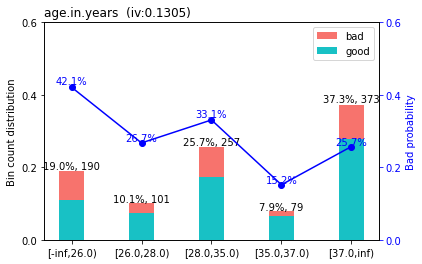

In [25]:
sc.woebin_plot(bins["age.in.years"])

{'credit.amount': <Figure size 432x288 with 2 Axes>}

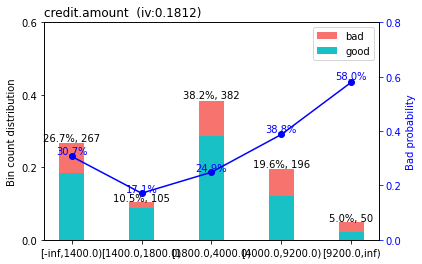

In [26]:
sc.woebin_plot(bins["credit.amount"])

从变量的分布图，看出bad_prob、credit.amount这两个变量并不单调，接下来就需要调整一下区间。

### 分箱调整
- scorecardpy可以自定义分箱，也可以自动分箱。
- 自己手动调整比较好（根据业务，实际经验调整）

In [27]:
# 自动分箱
# break_adj = sc.woebin_adj(dt_s,y="creditability",bins=bins)

In [28]:
bins["credit.amount"]

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,credit.amount,"[-inf,1400.0)",267,0.267,185,82,0.307116,0.033661,0.000305,0.18122,1400.0,False
1,credit.amount,"[1400.0,1800.0)",105,0.105,87,18,0.171429,-0.728239,0.046815,0.18122,1800.0,False
2,credit.amount,"[1800.0,4000.0)",382,0.382,287,95,0.248691,-0.258307,0.024109,0.18122,4000.0,False
3,credit.amount,"[4000.0,9200.0)",196,0.196,120,76,0.387755,0.390539,0.031987,0.18122,9200.0,False
4,credit.amount,"[9200.0,inf)",50,0.050,21,29,0.580000,1.170071,0.078005,0.18122,inf,False


- 将年龄划分在\[-inf,26.0)，[26.0,35.0)，[35.0,40.0)，[40.0,inf)区间大致能满足单调性。
- 金额划分在[-inf,1400.0)，[1400.0,1900.0)，[1900.0,4000.0)，[4000.0,inf)区间大致能满足单调性。

In [29]:
# 手动分箱
break_adj = {
    'age.in.years':[26,35,40],
    'credit.amount':[1400,1900,4000]
}
bins_adj = sc.woebin(dt_s,y="creditability",breaks_list=break_adj)

[INFO] creating woe binning ...


In [30]:
bins_adj_df = pd.concat(bins_adj).reset_index().drop(columns="level_0")

In [31]:
bins_adj_df[bins_adj_df.variable.isin(["age.in.years",'credit.amount'])]

,level_1,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,0,age.in.years,"[-inf,26.0)",190,0.190,110,80,0.421053,0.528844,0.057921,0.112742,26.0,False
1,1,age.in.years,"[26.0,35.0)",358,0.358,246,112,0.312849,0.060465,0.001324,0.112742,35.0,False
2,2,age.in.years,"[35.0,40.0)",153,0.153,123,30,0.196078,-0.563689,0.042679,0.112742,40.0,False
3,3,age.in.years,"[40.0,inf)",299,0.299,221,78,0.260870,-0.194156,0.010817,0.112742,inf,False
17,0,credit.amount,"[-inf,1400.0)",267,0.267,185,82,0.307116,0.033661,0.000305,0.141144,1400.0,False
18,1,credit.amount,"[1400.0,1900.0)",131,0.131,104,27,0.206107,-0.501256,0.029359,0.141144,1900.0,False
19,2,credit.amount,"[1900.0,4000.0)",356,0.356,270,86,0.241573,-0.296777,0.029395,0.141144,4000.0,False
20,3,credit.amount,"[4000.0,inf)",246,0.246,141,105,0.426829,0.552498,0.082085,0.141144,inf,False


{'age.in.years': <Figure size 432x288 with 2 Axes>}

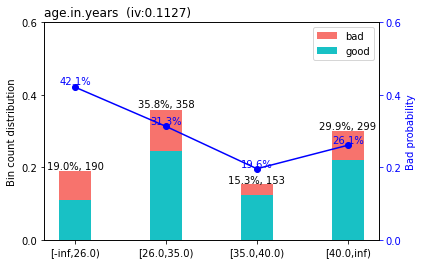

In [32]:
sc.woebin_plot(bins_adj["age.in.years"])

{'credit.amount': <Figure size 432x288 with 2 Axes>}

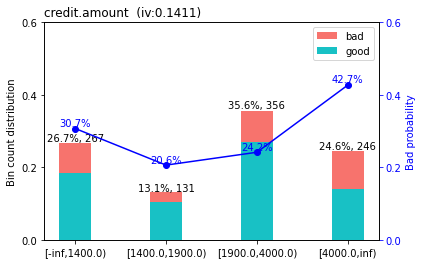

In [33]:
sc.woebin_plot(bins_adj['credit.amount'])

## WOE转化
将原始数据都转化为对应区间的WOE值，当然也可以不转化，但是转化之后：
- 变量内部之间可以比较
- 变量与变量之间也可以比较
- 所有变量都在同一“维度”下

In [34]:
train_woe = sc.woebin_ply(train,bins_adj)

[INFO] converting into woe values ...


In [35]:
test_woe = sc.woebin_ply(test,bins_adj)

[INFO] converting into woe values ...


In [36]:
train_woe.sample(5)

,creditability,age.in.years_woe,purpose_woe,credit.history_woe,housing_woe,installment.rate.in.percentage.of.disposable.income_woe,credit.amount_woe,personal.status.and.sex_woe,present.employment.since_woe,status.of.existing.checking.account_woe,property_woe,savings.account.and.bonds_woe,duration.in.month_woe
356,0,-0.194156,-0.410063,-0.733741,-0.194156,-0.251314,-0.296777,-0.165548,-0.235566,-1.176263,-0.461035,-0.762140,-0.346625
361,0,-0.563689,-0.410063,0.088319,-0.194156,-0.155466,-0.296777,-0.165548,-0.235566,-0.405465,0.034191,-0.762140,-0.346625
444,1,0.060465,0.279920,-0.733741,-0.194156,-0.155466,0.552498,0.264693,0.032103,0.614204,0.034191,0.271358,1.134980
818,0,-0.194156,0.279920,0.088319,-0.194156,-0.155466,0.552498,0.264693,0.431137,0.614204,0.034191,0.271358,0.524524
985,0,0.528844,0.279920,-0.733741,0.404445,0.103961,-0.501256,0.264693,0.032103,0.614204,0.028573,0.271358,-0.346625


## 建立模型
逻辑回归，挺复杂的。

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
y_train = train_woe.loc[:,"creditability"]
X_train = train_woe.loc[:,train_woe.columns!="creditability"]

In [39]:
y_test = test_woe.loc[:,"creditability"]
X_test = test_woe.loc[:,test_woe.columns!="creditability"]

In [40]:
lr = LogisticRegression(penalty='l1',C=0.9,solver='saga',n_jobs=-1)
lr.fit(X_train,y_train)

LogisticRegression(C=0.9, n_jobs=-1, penalty='l1', solver='saga')

In [41]:
lr.coef_

array([[0.68933729, 0.99455906, 0.63123048, 0.36662887, 1.68190639,
        0.77889437, 0.70444067, 0.23646028, 0.75918453, 0.37599569,
        0.50149576, 0.60000325]])

In [42]:
lr.intercept_

array([-0.82462777])

## 模型评估
逻辑回归，预测结果为接近1的概率值。  
0.6表示：数据划分为标签1的概率为0.6。那么究竟多大的概率才能划为标签1呢？这就需要一个阈值。这个阈值可以根据KS的值来确定。高于阈值得划分为1标签，低于阈值得划分为0标签。

TRP与FRP：
$$
TRP=\frac{预测为1，真实值为1的数据量}{预测为1的总量}
$$
$$
FRP=\frac{预测为0，真实值为1的数据量}{预测为0的总量}
$$  
ROC曲线绘制步骤：
1. 将预测的y_score去重排序后得到一系列阈值。
2. 用每一个y_score做为阈值，统计数量并计算TRP、FRP的值。
3. 这样得到一组数据后，以FPR为横坐标，TPR为纵轴标绘制图像。

AUC：
- ROC曲线与横坐标轴围成的面积。

KS曲线：用来确定最好的阈值
$$
KS=max(TRP-FRP)
$$
- x轴为一些阈值的长度（区间序号都行），将TRP、FRP绘制在同一个坐标轴中。

In [43]:
train_pred = lr.predict_proba(X_train)[:,1]
test_pred =  lr.predict_proba(X_test)[:,1]

/opt/anaconda/lib/python3.7/site-packages/scorecardpy/perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)
/opt/anaconda/lib/python3.7/site-packages/scorecardpy/perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)


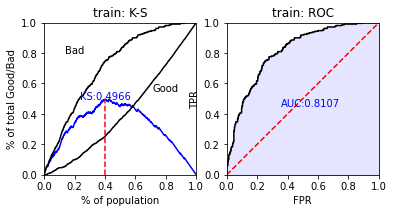

In [44]:
train_perf = sc.perf_eva(y_train,train_pred,title="train")

/opt/anaconda/lib/python3.7/site-packages/scorecardpy/perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)
/opt/anaconda/lib/python3.7/site-packages/scorecardpy/perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)


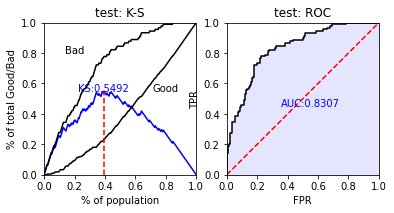

In [45]:
test_perf = sc.perf_eva(y_test,test_pred,title="test")

## 评分映射
参考地址：https://github.com/xsj0609/data_science/tree/master/ScoreCard  
逻辑回归结果：
$$
f(x)=\beta_0+\beta_1x_1+\beta_2x_2+...+\beta_nx_n
$$
评分计算公式：
$$
Score=A-B*log(\frac{p}{1-p})，p：客户违约率
$$
计算评分前需要先给出两个条件：
1. 给定某个违约率$\theta_0$，对应的分数$P_0$。scorecardpy默认$\theta_0=\frac{1}{19}，P_0=600$
2. 当违约率$\theta_0$翻一番的时候，分数变化幅度$PDO$。scorecardpy默认$PDO=50$  

通过推导可以计算出：  

$$B=\frac{PDO}{log(2)}，A=P_0+B*log(\theta_0)，log(\frac{p}{1-p})=f(x)$$
举例说明：  

### 计算基础分：

In [48]:
import math

In [49]:
B = 50/math.log(2)
A = 600+B*math.log(1/19)
basepoints=A-B*lr.intercept_[0]
print("A:",A,"B:",B,"basepoints:",basepoints)

A: 387.6036243278207 B: 72.13475204444818 basepoints: 447.08794370132955


### credit.amount分数的计算过程

In [50]:
bins_adj_df[bins_adj_df["variable"]=="credit.amount"]

,level_1,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
17,0,credit.amount,"[-inf,1400.0)",267,0.267,185,82,0.307116,0.033661,0.000305,0.141144,1400.0,False
18,1,credit.amount,"[1400.0,1900.0)",131,0.131,104,27,0.206107,-0.501256,0.029359,0.141144,1900.0,False
19,2,credit.amount,"[1900.0,4000.0)",356,0.356,270,86,0.241573,-0.296777,0.029395,0.141144,4000.0,False
20,3,credit.amount,"[4000.0,inf)",246,0.246,141,105,0.426829,0.552498,0.082085,0.141144,inf,False


In [51]:
lr.coef_

array([[0.68933729, 0.99455906, 0.63123048, 0.36662887, 1.68190639,
        0.77889437, 0.70444067, 0.23646028, 0.75918453, 0.37599569,
        0.50149576, 0.60000325]])

In [52]:
lr.intercept_

array([-0.82462777])

In [53]:
# [-inf,1400.0)区间分数，按照顺序，对应的系数为0.77881419
-B*0.77881419*0.033661

-1.8910604547516296

In [54]:
# [1400.0,1900.0)
-B*0.77881419*(-0.501256)

28.160345780190216

### 计算所有区间分数：

In [55]:
card = sc.scorecard(bins_adj,lr,X_train.columns)

In [56]:
card_df = pd.concat(card)

In [57]:
card_df

variable  \
basepoints                                         0                                          basepoints   
age.in.years                                       0                                        age.in.years   
                                                   1                                        age.in.years   
                                                   2                                        age.in.years   
                                                   3                                        age.in.years   
purpose                                            4                                             purpose   
                                                   5                                             purpose   
                                                   6                                             purpose   
credit.history                                     7                                      credit.history   
                                                   8                                      credit.history   
                                                   9                                      credit.history   
                                                   10                                     credit.history   
housing                                            11                                            housing   
                                                   12                                            housing   
                                                   13                                            housing   
installment.rate.in.percentage.of.disposable.in... 14  installment.rate.in.percentage.of.disposable.i...   
                                                   15  installment.rate.in.percentage.of.disposable.i...   
                                                   16  installment.rate.in.percentage.of.disposable.i...   
credit.amount                                      17                                      credit.amount   
                                                   18                                      credit.amount   
                                                   19                                      credit.amount   
                                                   20                                      credit.amount   
personal.status.and.sex                            21                            personal.status.and.sex   
                                                   22                            personal.status.and.sex   
                                                   23                            personal.status.and.sex   
present.employment.since                           24                           present.employment.since   
                                                   25                           present.employment.since   
                                                   26                           present.employment.since   
                                                   27                           present.employment.since   
status.of.existing.checking.account                28                status.of.existing.checking.account   
                                                   29                status.of.existing.checking.account   
                                                   30                status.of.existing.checking.account   
property                                           31                                           property   
                                                   32                                           property   
                                                   33                                           property   
                                                   34                                           property   
savings.account.and.bonds                          35                          savings.account.and.b

每个变量的每个区间的分数计算完成，将客户的数据对应到区间，将分数相加，即可得出对应的评分。

## 评分稳定性分析
PSI（Population Stability Index）群组稳定性指标
- 模型在训练数据得到的实际分布(A)，与测试集上得到的预期分布(E)
$$
PSI=\sum_{i=1}^n(A_i-E_i)*ln(\frac{A_i}{E_i})
$$
$A_i：实际分布在第i个区间的数量。$  
$E_i：预期分布在第i个区间的数量。$ 

PSI越小，说明模型越稳定。通常PSI小于0.1，模型稳定性好。

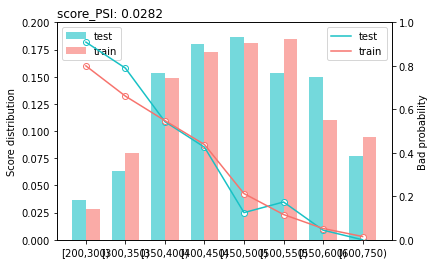

{'psi':   variable       PSI
 0    score  0.028244, 'pic': {'score': <Figure size 432x288 with 2 Axes>}}

In [47]:
card = sc.scorecard(bins_adj,lr,X_train.columns)
train_score = sc.scorecard_ply(train, card, print_step=0)
test_score = sc.scorecard_ply(test, card, print_step=0)

sc.perf_psi(
    score = {'train':train_score,'test':test_score},
    label = {'train':y_train,'test':y_test}
)

## 评分卡的提升度分析
参考文章：https://www.jianshu.com/p/ff0eb70d31ec  
提升度，模型捕捉到的还账率/样本真实的坏账率  
- 步骤：
    1. 将数据按照分数升序排列，平均分为10组
    2. 计算每一组模型的坏账率（y=1的数量/总体y=1的数量）
    3. 计算每一组应该的坏账率（该组的样本量*总体的坏账率）/（总体y=1的数量）
    4. 该组的提升度就是累计的模型坏账率/累计的应该坏账率   

Lift是评估一个预测模型是否有效的一个度量；它衡量的是一个模型（或规则）对目标中“响应”的预测能力优于随机选择的倍数，以1为界线，大于1的Lift表示该模型或规则比随机选择捕捉了更多的“响应”，等于1的Lift表示该模型的表现独立于随机选择，小于1则表示该模型或规则比随机选择捕捉了更少的“响应”。维基百科中提升度被解释为“Target response divided by average response”。

In [64]:
train_score = sc.scorecard_ply(train, card, print_step=0)

In [67]:
train_score["y"] = y_train

In [77]:
train_score_sorted = train_score.sort_values(by="score",ascending=True)

In [183]:
# train_score_sorted.to_csv("./score_lift.csv")

In [82]:
# 将数据分为10组，每组70个样本
train_score_sorted["group"] = [1]*70+[2]*70+[3]*70+[4]*70+[5]*70+[6]*70+[7]*70+[8]*70+[9]*70+[10]*70

In [173]:
group_df = train_score_sorted.groupby(by="group",as_index=False).agg({"score":"count","y":"sum"})

In [174]:
group_df["bad_model_rate"] = group_df["y"]/group_df["y"].sum()

In [175]:
group_df["bad_random_rate"] = group_df["score"]/group_df["score"].sum()

In [176]:
group_df["cum_model_rate"] = group_df["bad_model_rate"].cumsum()

In [177]:
group_df["cum_random_rate"] = group_df["bad_random_rate"].cumsum()

In [178]:
group_df["lift"] = group_df["cum_model_rate"]/group_df["cum_random_rate"]

In [179]:
group_df.rename(columns={"y":"bad","score":"obs"},inplace=True)

In [180]:
group_df

,group,obs,bad,bad_model_rate,bad_random_rate,cum_model_rate,cum_random_rate,lift
0,1,70,47,0.223810,0.1,0.223810,0.1,2.238095
1,2,70,44,0.209524,0.1,0.433333,0.2,2.166667
2,3,70,32,0.152381,0.1,0.585714,0.3,1.952381
3,4,70,34,0.161905,0.1,0.747619,0.4,1.869048
4,5,70,16,0.076190,0.1,0.823810,0.5,1.647619
5,6,70,16,0.076190,0.1,0.900000,0.6,1.500000
6,7,70,9,0.042857,0.1,0.942857,0.7,1.346939
7,8,70,8,0.038095,0.1,0.980952,0.8,1.226190
8,9,70,3,0.014286,0.1,0.995238,0.9,1.105820
9,10,70,1,0.004762,0.1,1.000000,1.0,1.000000


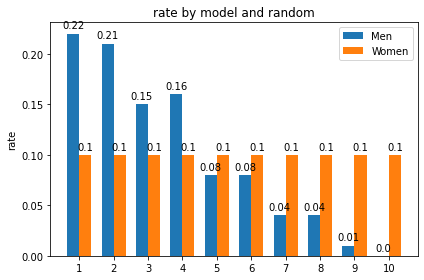

In [111]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = group_df["group"].tolist()
men_means = [round(i,2) for i in group_df["bad_model_rate"].tolist()]
women_means = [round(i,2) for i in group_df["bad_random_rate"].tolist()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('rate')
ax.set_title('rate by model and random')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

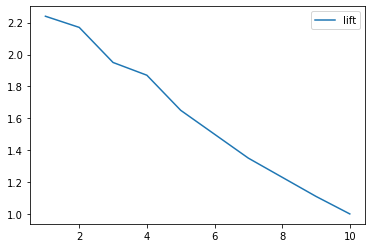

In [120]:
cat = [round(i,2) for i in group_df["lift"].tolist()]
activity = group_df["group"].tolist()

fig, ax = plt.subplots()
ax.plot(activity, cat,label="lift")
ax.legend()
plt.show()